# **Modules**

In [1]:
# Util libraries
import os
import re
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
#!pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

# SKLearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report

# Tensorflow Keras
# !pip install tensorflow
# !pip install keras
import tensorflow as tf
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.utils import to_categorical

# **Read Data**

In [2]:
# Company ticker symbol
# Current available options: AAPL, BA, TSLA
ticker = "TSLA"

# Data files
stock_price_file = f"../data/{ticker}/raw_data/daily_{ticker}.csv"
news_file = f"../data/{ticker}/raw_data/news_{ticker}.json"

# Read the stock price data
stock_price_df = pd.read_csv(stock_price_file)

# Read the news data
news_df = pd.read_json(news_file)

# **Preprocess Stock Price Data**

In [3]:
# Inspect the stock price data
stock_price_df.head()

,timestamp,open,high,low,close,volume
0,2020-11-06,436.10,436.5700,424.2800,429.95,21706014
1,2020-11-05,428.30,440.0000,424.0001,438.09,28414523
2,2020-11-04,430.62,435.4000,417.1000,420.98,32143057
3,2020-11-03,409.73,427.7700,406.6900,423.90,34351715
4,2020-11-02,394.00,406.9799,392.3000,400.51,29021118


In [4]:
def label_diff(row):
  # Label the difference (one-hot-encoding)
  # [0, 0, 0] - Trend Stay
  # [0, 1, 0] - Trend Up
  # [0, 0, 2] - Trend Down

  # Return [0, 0, 0] (Trend Stay) if NaN
  if row["diff"] == "NaN":
    label_count["stay"] += 1
    return [0, 0, 0]
  
  # Return [0, 1, 0] (Trend Up) if price difference between today and yesterday is >= $5
  elif row["diff"] >= 2:
    label_count["up"] += 1
    return [0, 1, 0]
  
  # Return [0, 0, 1] (Trend Down) if price difference between today and yesterday is <= -$5
  elif row["diff"] <= -2:
    label_count["down"] += 1
    return [0, 0, 1]
  
  # Else, return [0, 0, 0] (Trend Stay)
  else:
    label_count["stay"] += 1
    return [0, 0, 0]

In [5]:
# Keep track of the count per classes/ labels
label_count = {
    "stay": 0,
    "up": 0,
    "down": 0
}

# Subset the stock price date range according to the news data
stock_price_df = stock_price_df[stock_price_df["timestamp"].isin(news_df["publishedAt"])][["timestamp", "open"]].sort_values(by=['timestamp'])

# Calculate the price difference based on previous day's open price
stock_price_df["diff"] = stock_price_df["open"].diff()

# Create label based on price difference
label = stock_price_df.apply(lambda row: label_diff(row), axis = 1)
stock_price_df["label"] = label

stock_price_df

,timestamp,open,diff,label
22,2020-10-07,419.8700,NaN,"[0, 0, 0]"
21,2020-10-08,438.4400,18.5700,"[0, 1, 0]"
20,2020-10-09,430.1300,-8.3100,"[0, 0, 1]"
19,2020-10-12,442.0000,11.8700,"[0, 1, 0]"
18,2020-10-13,443.3500,1.3500,"[0, 0, 0]"
17,2020-10-14,449.7800,6.4300,"[0, 1, 0]"
16,2020-10-15,450.3100,0.5300,"[0, 0, 0]"
15,2020-10-16,454.4400,4.1300,"[0, 1, 0]"
14,2020-10-19,446.2400,-8.2000,"[0, 0, 1]"
13,2020-10-20,431.7500,-14.4900,"[0, 0, 1]"


In [6]:
# Lowest and highest open price
print("Lowest  open price:", min(list(stock_price_df["open"])))
print("Highest open price:", max(list(stock_price_df["open"])))

Lowest  open price: 394.0
Highest open price: 454.44


In [7]:
# Label count for each class
print("Labels count:", label_count)

Labels count: {'stay': 3, 'up': 9, 'down': 11}


# **Merge News & Stock Data**

In [8]:
# Inspect the news data
news_df.head()

,title,description,publishedAt
0,Tesla finally launches two-factor authentication,"b'After a long string of delays, Tesla has fin...",2020-10-07
1,Tesla has a shot at producing half a million c...,b'Tesla Inc <TSLA.O> has a chance at producing...,2020-10-07
2,Ex,"b""Tesla co-founder J.B. Straubel wants to buil...",2020-10-07
3,SpaceX has launched enough satellites for Star...,b'Timeline uncertain because newly launched sa...,2020-10-07
4,SpaceX doubled down on clearing out the villag...,"b""Summary List PlacementSpaceX has made what i...",2020-10-07


In [9]:
# Merge on timestamp
news_stock_label_df = pd.merge(news_df, stock_price_df[["timestamp", "label"]], left_on="publishedAt", right_on="timestamp")[["title", "description", "timestamp", "label"]]

# Label is the stock trend movement: 
# [0, 0, 0] - Stay
# [0, 1, 0] - Up
# [0, 0, 1] - Down
news_stock_label_df

,title,description,timestamp,label
0,Tesla finally launches two-factor authentication,"b'After a long string of delays, Tesla has fin...",2020-10-07,"[0, 0, 0]"
1,Tesla has a shot at producing half a million c...,b'Tesla Inc <TSLA.O> has a chance at producing...,2020-10-07,"[0, 0, 0]"
2,Ex,"b""Tesla co-founder J.B. Straubel wants to buil...",2020-10-07,"[0, 0, 0]"
3,SpaceX has launched enough satellites for Star...,b'Timeline uncertain because newly launched sa...,2020-10-07,"[0, 0, 0]"
4,SpaceX doubled down on clearing out the villag...,"b""Summary List PlacementSpaceX has made what i...",2020-10-07,"[0, 0, 0]"
...,...,...,...,...
472,"Tesla unveils 'Tesla Tequila' for $250, produc...",b'Tesla Inc <TSLA.O> Chief Executive Officer E...,2020-11-06,"[0, 1, 0]"
473,Waiting for a winner was costly and other inve...,b'Investors have traditionally shied away from...,2020-11-06,"[0, 1, 0]"
474,Toyota-backed startup Pony.ai raises $267 mill...,"b'Pony.ai, backed by Toyota Motor Corp, said o...",2020-11-06,"[0, 1, 0]"
475,Toyota-backed startup Pony.ai raises $267 mill...,"b'Pony.ai, backed by Toyota Motor Corp, said o...",2020-11-06,"[0, 1, 0]"


# **Preprocess News Data**

In [10]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

In [11]:
def clean_text(row):
    # Steps:
    # 1. Lowercase words (for uncased GloVe Embeddings)
    # 2. Replace contractions with longer form (from the contractions dictionary)
    # 3. Replace and remove non-word characters (symbols)
    # 4. Remove stop words
    
    # Lowercase words
    text = row.lower()
    
    # Replace contractions with longer form
    text = text.split()
    expanded_text = []
    for word in text:
        if word in contractions:
            expanded_text.append(contractions[word])
        else:
            expanded_text.append(word)
    text = " ".join(expanded_text)
    
    # Format words and remove non-word characters
    text = re.sub(r'b\"', '', text)
    text = re.sub(r'b\'', '', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]<>]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Remove stop words
    text = text.split()
    stop_words = set(stopwords.words("english"))
    text = [word for word in text if not word in stop_words]
    
    # Return cleaned text
    cleaned_text = " ".join(text)
    
    return cleaned_text

In [12]:
# Clean the news title text
news_stock_label_df["title"] = news_stock_label_df.apply(lambda row: clean_text(row["title"]), axis = 1)

# Clean the news description text
news_stock_label_df["description"] = news_stock_label_df.apply(lambda row: clean_text(row["description"]), axis = 1)

news_stock_label_df

,title,description,timestamp,label
0,tesla finally launches two factor authentication,long string delays tesla finally implemented c...,2020-10-07,"[0, 0, 0]"
1,tesla shot producing half million cars 2020 memo,tesla inc tsla chance producing 500000 cars ye...,2020-10-07,"[0, 0, 0]"
2,ex,tesla co founder j b straubel wants build star...,2020-10-07,"[0, 0, 0]"
3,spacex launched enough satellites starlink’s u...,timeline uncertain newly launched satellites m...,2020-10-07,"[0, 0, 0]"
4,spacex doubled clearing village building rocke...,summary list placementspacex made calls final ...,2020-10-07,"[0, 0, 0]"
...,...,...,...,...
472,tesla unveils tesla tequila $ 250 product sold...,tesla inc tsla chief executive officer elon mu...,2020-11-06,"[0, 1, 0]"
473,waiting winner costly investor lessons post el...,investors traditionally shied away uncertainty...,2020-11-06,"[0, 1, 0]"
474,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]"
475,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]"


In [13]:
# Calculate word frequency and the size of the vocabulary
def calculate_word_frequency(row, word_frequency):
    
    title_text = row["title"].split()
    for word in title_text:
        if word not in word_frequency:
            word_frequency[word] = 1
        else:
            word_frequency[word] += 1
    
    description_text = row["description"].split()
    for word in description_text:
        if word not in word_frequency:
            word_frequency[word] = 1
        else:
            word_frequency[word] += 1
    
    return word_frequency

In [14]:
# Calculate word frequency and the size of the vocabulary
word_frequency = {}

news_stock_label_df.apply(lambda row: calculate_word_frequency(row, word_frequency), axis = 1)

print("Size of vocabulary: {}".format(len(word_frequency)))

Size of vocabulary: 4028


In [15]:
# Sort by word frequency (descending order starting from highest count word)
word_frequency = {k: v for k, v in sorted(word_frequency.items(), key=lambda item: item[1], reverse=True)}

# Print the list of vocabulary
for word, frequency in word_frequency.items():
    print(word, frequency)

tesla 354
$ 171
musk 166
elon 148
electric 126
new 95
company 86
spacex 82
said 80
summary 79
driving 79
year 73
battery 73
list 72
self 68
states 65
says 63
model 63
united 62
car 62
vehicle 59
placement 56
first 52
full 52
ceo 51
cars 51
price 48
million 46
space 46
3 44
ev 43
starlink 42
billion 39
one 38
beta 36
china 36
wednesday 35
internet 35
us 35
tuesday 34
vehicles 34
quarter 34
two 32
investors 32
inc 31
1 31
twitter 31
startup 30
could 30
tech 30
software 30
000 30
stocks 30
— 29
made 29
people 29
next 29
tequila 29
tsla 28
chief 28
according 28
stimulus 28
2 28
would 28
world 27
years 27
profit 27
street 27
high 26
market 26
executive 25
lg 25
chem 25
sales 25
rocket 24
5 24
maker 24
record 24
satellite 24
reuters 23
technology 23
public 23
like 23
launch 23
big 23
wall 23
hummer 23
2020 22
told 22
top 22
500 22
third 22
system 22
business 22
week 22
reported 21
range 21
may 21
plans 21
month 21
version 21
motors 21
build 20
companies 20
production 20
get 20
thursday 20
se

buying 3
benz 3
vision 3
finds 3
cheaper 3
picks 3
track 3
custom 3
alexa 3
decade 3
using 3
closer 3
60 3
star 3
4680 3
roadster 3
dubbed 3
planet 3
pushing 3
milestone 3
signs 3
falcon 3
found 3
way 3
22 3
opportunities 3
gold 3
slump 3
sometimes 3
scheduled 3
political 3
approval 3
transport 3
jb 3
often 3
hand 3
leaving 3
pretty 3
enter 3
cause 3
oct 3
epa 3
young 3
launching 3
regulators 3
portfolios 3
antitrust 3
actions 3
seem 3
perfect 3
moment 3
supersonic 3
faster 3
plane 3
alongside 3
cybertrucks 3
commission 3
25 3
sensors 3
believe 3
anyone 3
low 3
tribe 3
getting 3
carmaker 3
2017 3
deliver 3
weekly 3
newsletter 3
finance 3
personal 3
channel 3
mike 3
jumped 3
forecasts 3
executives 3
wealth 3
current 3
leader 3
six 3
cuts 3
bhp 3
credentials 3
leaf 3
owned 3
australian 3
looking 3
expected 3
rapper 3
happened 3
20000 3
lives 3
opinion 3
non 3
virus 3
done 3
nothing 3
turned 3
millions 3
odds 3
jokes 3
response 3
updated 3
affordable 3
trains 3
dishes 3
objects 3
wrote 3


gabe 2
zealand 2
pe 2
chaikin 2
invitations 2
id 2
2023 2
exploding 2
lows 2
spikes 2
cohort 2
walmart 2
humans 2
raspberry 2
pi 2
keyboard 2
massachusetts 2
voters 2
electoral 2
liquor 2
joke 2
germany 2
individual 2
skydio 2
enterprise 2
c 2
victoria 2
seeing 2
renowned 2
strange 2
install 2
bentley 2
totally 2
lightning 2
shaped 2
hefty 2
effort 2
resellers 2
empty 2
linear 2
jab 2
sport 2
lineup 2
galactic 2
lonsdale 2
phase 2
string 1
implemented 1
crucial 1
te 1
starlink’s 1
uncertain 1
newly 1
clearing 1
placementspacex 1
remaining 1
boca 1
chica 1
1960s 1
beachside 1
neighborhood 1
wildlife 1
rich 1
southeastern 1
tip 1
reso 1
slips 1
ends 1
talksreuters 1
maliciously 1
sabotaging 1
worker 1
act 1
sabotage 1
fremont 1
infosec 1
determined 1
sic 1
wealthier 1
shock 1
pocket 1
hits 1
goals 1
trailing 1
ebitda 1
shy 1
unlock 1
secured 1
2fa 1
layer 1
authenticator 1
apps 1
tom 1
versace 1
giorgio 1
armani 1
recycler 1
metal 1
sight 1
gather 1
notably 1
accessibility 1
assistive 1


megabits 1
estonia 1
estonian 1
storage 1
41 1
euros 1
cleantech 1
rounds 1
waffling 1
riddled 1
spelling 1
mistakes 1
dark 1
web 1
ha 1
av 1
partnerships 1
abound 1
busy 1
expressions 1
interest 1
pilot 1
scooter 1
infect 1
victim 1
file 1
encrypting 1
malware 1
files 1
ransom 1
notoriety 1
battle 1
jim 1
bridenstine 1
congressman 1
oklahoma 1
valve’s 1
eccentric 1
thank 1
game 1
valve 1
streamed 1
rallies 1
310 1
posting 1
slide 1
undoubtedly 1
attitude 1
materialize 1
chamber 1
ban 1
tester 1
terminal 1
forest 1
120mbps 1
feels 1
amazed 1
works 1
spacex\ 1
company\ 1
participation 1
thous 1
stephan 1
woellenstein 1
nominations 1
dissolved 1
demonstrating 1
willingness 1
actively 1
publicity 1
outlets 1
advertising 1
agencies 1
age 1
housing 1
designing 1
habitats 1
celebrated 1
continuous 1
lived 1
aboard 1
2000 1
refining 1
aka 1
upd 1
abandons 1
store 1
inventories 1
cant 1
replace 1
automate 1
chore 1
find 1
macs 1
pc 1
cybertuck 1
impose 1
settlements 1
dubious 1
seriously 1
any

# **Visualize News Data**

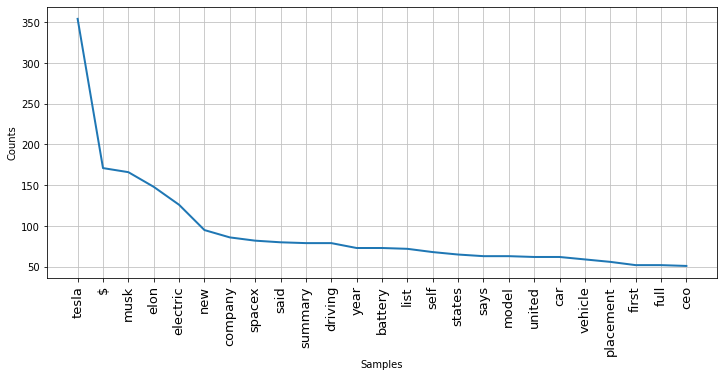

In [16]:
# Plot word frequency distribution
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(word_frequency)
fd.plot(25,cumulative=False)

# Log-log of all words 
word_counts = sorted(Counter(word_frequency).values(), reverse=True)

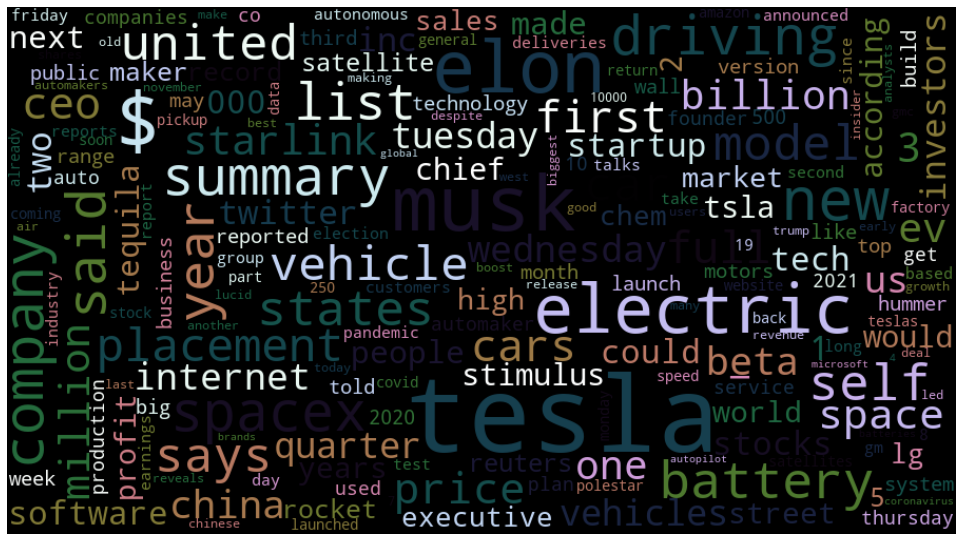

In [17]:
# Generate Word Cloud
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(word_frequency)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **NLTK Vader Sentiment Lexicon**
Calculate sentiment polarity of sentence

In [18]:
def calculate_sentiment_polarity(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)  

    return sentiment_score["compound"]

In [19]:
# Calculate the sentiment polarity of the news title text
news_stock_label_df["title_sentiment"] = news_stock_label_df.apply(lambda row: calculate_sentiment_polarity(row["title"]), axis = 1)

# Calculate the sentiment polarity of the news description text
news_stock_label_df["description_sentiment"] = news_stock_label_df.apply(lambda row: calculate_sentiment_polarity(row["description"]), axis = 1)

news_stock_label_df

,title,description,timestamp,label,title_sentiment,description_sentiment
0,tesla finally launches two factor authentication,long string delays tesla finally implemented c...,2020-10-07,"[0, 0, 0]",0.0000,0.3400
1,tesla shot producing half million cars 2020 memo,tesla inc tsla chance producing 500000 cars ye...,2020-10-07,"[0, 0, 0]",0.0000,0.2500
2,ex,tesla co founder j b straubel wants build star...,2020-10-07,"[0, 0, 0]",0.0000,0.2023
3,spacex launched enough satellites starlink’s u...,timeline uncertain newly launched satellites m...,2020-10-07,"[0, 0, 0]",0.1280,-0.1531
4,spacex doubled clearing village building rocke...,summary list placementspacex made calls final ...,2020-10-07,"[0, 0, 0]",-0.1280,0.5574
...,...,...,...,...,...,...
472,tesla unveils tesla tequila $ 250 product sold...,tesla inc tsla chief executive officer elon mu...,2020-11-06,"[0, 1, 0]",0.0000,0.5994
473,waiting winner costly investor lessons post el...,investors traditionally shied away uncertainty...,2020-11-06,"[0, 1, 0]",0.5267,0.1586
474,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]",0.0258,0.6808
475,toyota backed startup pony ai raises $ 267 mil...,pony ai backed toyota motor corp said friday r...,2020-11-06,"[0, 1, 0]",0.0258,0.8074


# **Load GloVe's Embeddings**

In [20]:
# GloVe's Embeddings Credit to: https://nlp.stanford.edu/projects/glove/
# Download from: http://nlp.stanford.edu/data/glove.42B.300d.zip
embeddings_file = "../embeddings/glove.42B.300d.txt"

# Load GloVe's embeddings
embeddings_index = {}

with open(embeddings_file, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 1917494


In [21]:
# Find the # of words in our vocabulary that are missing from GloVe
missing_words = 0

for word, frequency in word_frequency.items():
    if word not in embeddings_index:
        missing_words += 1

# Calculate the % of missing words
missing_words_ratio = round(missing_words/len(word_frequency) * 100, 2) 

print("Number  of words missing from GloVe:", missing_words)
print("Percent of words missing from GloVe: {}%".format(missing_words_ratio))

Number  of words missing from GloVe: 150
Percent of words missing from GloVe: 3.72%


In [22]:
# Create a word_to_integer dictionary to map words to integers
word_to_integer = {}

integer = 0
for word, frequency in word_frequency.items():
    word_to_integer[word] = integer
    integer += 1

# Special tokens (unknown, padding) to add to our word_to_integer dictionary
tokens = ["<UNK>","<PAD>"]   

# Add the special tokens to our word_to_integer dictionary
for token in tokens:
    word_to_integer[token] = len(word_to_integer)
    
# Create an integer_to_word dictionary to map integers back to words
integer_to_word = {}
for word, integer, in word_to_integer.items():
    integer_to_word[integer] = word

# Check the size of the word_to_integer dictionary
print("Size of word_to_integer dictionary: {}".format(len(word_to_integer)))

Size of word_to_integer dictionary: 4030


In [23]:
# Set embedding dimension to 300 (based on GloVe's vector size)
embedding_dim = 300
vocab_dim = len(word_to_integer) # Size of vocabulary

# Initialize an embedding matrix with zeroes
embedding_matrix = np.zeros((vocab_dim, embedding_dim))

for word, integer in word_to_integer.items():
    # Look up the word vectors from the GloVe embeddings (embeddings_index)
    # Bootstrap the embedding_matrix with the word vectors
    if word in embeddings_index:
        embedding_matrix[integer] = embeddings_index[word]
    else:
        # If a word is not in GloVe, initialize a random vector of size 300 for the missing word
        randomized_vector = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        
        embeddings_index[word] = randomized_vector     # Include the vector into GloVe embeddings
        embedding_matrix[integer] = randomized_vector  # Include the vector into the embedding matrix
        
# Sanity check if the length of the embedding matrix matches our length of word_to_integer
print("Size of embedding matrix: {}".format(np.shape(embedding_matrix)))

Size of embedding matrix: (4030, 300)


# **Convert news text to integers**

In [24]:
# Convert text to an array of integers based on the word_to_integer dictionary
def convert_text_to_integer(row, max_length, text_type):
    text_as_integers = []
    
    text = row[text_type].split(" ")
    for word in text:
        # If word exists in our word_to_integers dictionary, then convert the word to its respective integer
        if word in word_to_integer:
            text_as_integers.append(word_to_integer[word])
        # Else, replace it with <UNK> unknown
        else:
            text_as_integers.append(word_to_integer["<UNK>"])
    
    max_length[text_type] = str(len(text_as_integers)) if len(text_as_integers) > int(max_length[text_type]) else str(max_length[text_type])
    
    return text_as_integers

In [25]:
# Keep track of the maximum lengths of the news title text and description
max_length = {
    "title": 0,
    "description": 0
}

# Convert news title text to integers
news_stock_label_df["title"] = news_stock_label_df.apply(lambda row: convert_text_to_integer(row, max_length, "title"), axis = 1)

# Convert news description text to integers
news_stock_label_df["description"] = news_stock_label_df.apply(lambda row: convert_text_to_integer(row, max_length, "description"), axis = 1)

# Print the max. length of title and description
print("Max length of title:       {}".format(max_length["title"]))
print("Max length of description: {}".format(max_length["description"]))


Max length of title:       27
Max length of description: 39


In [26]:
# Pad text to max length to ensure same dimension
def pad_text_to_max_length(row, max_length, text_type, truncate=False, truncate_no=0):
    int_text = row[text_type]
    while len(int_text) < int(max_length[text_type]):
        int_text.append(word_to_integer["<PAD>"])
    
    # Cut-off at certain text length
    if truncate:
        int_text = int_text[:truncate_no]
    
    return int_text

In [27]:
# Pad news title (int) text
news_stock_label_df["title"] = news_stock_label_df.apply(lambda row: pad_text_to_max_length(row, max_length, "title"), axis=1)

# Pad news description (int) text
news_stock_label_df["description"] = news_stock_label_df.apply(lambda row: pad_text_to_max_length(row, max_length, "description"), axis=1)


In [28]:
news_stock_label_df

,title,description,timestamp,label,title_sentiment,description_sentiment
0,"[0, 255, 460, 42, 708, 709, 4029, 4029, 4029, ...","[123, 1991, 574, 0, 255, 1992, 1993, 710, 349,...",2020-10-07,"[0, 0, 0]",0.0000,0.3400
1,"[0, 922, 461, 711, 27, 25, 87, 1278, 4029, 402...","[0, 44, 58, 712, 461, 462, 25, 11, 59, 70, 291...",2020-10-07,"[0, 0, 0]",0.0000,0.2500
2,"[714, 4029, 4029, 4029, 4029, 4029, 4029, 4029...","[0, 114, 115, 1279, 715, 463, 352, 102, 47, 12...",2020-10-07,"[0, 0, 0]",0.0000,0.2023
3,"[7, 142, 923, 143, 1995, 716, 81, 34, 4029, 40...","[924, 1996, 1997, 142, 143, 925, 717, 464, 718...",2020-10-07,"[0, 0, 0]",0.1280,-0.1531
4,"[7, 926, 1998, 1282, 465, 74, 1283, 927, 580, ...","[9, 13, 1999, 54, 401, 929, 582, 402, 2000, 58...",2020-10-07,"[0, 0, 0]",-0.1280,0.5574
...,...,...,...,...,...,...
472,"[0, 593, 0, 57, 1, 159, 389, 253, 148, 4029, 4...","[0, 44, 58, 59, 70, 291, 3, 2, 255, 54, 179, 5...",2020-11-06,"[0, 1, 0]",0.0000,0.5994
473,"[1511, 4016, 1382, 413, 4017, 524, 122, 277, 1...","[43, 4018, 4019, 416, 4020, 4021, 1595, 4022, ...",2020-11-06,"[0, 1, 0]",0.5267,0.1586
474,"[398, 559, 47, 920, 477, 339, 1, 921, 27, 5, 3...","[920, 477, 559, 398, 386, 219, 8, 128, 249, 1,...",2020-11-06,"[0, 1, 0]",0.0258,0.6808
475,"[398, 559, 47, 920, 477, 339, 1, 921, 27, 209,...","[920, 477, 559, 398, 386, 219, 8, 128, 249, 1,...",2020-11-06,"[0, 1, 0]",0.0258,0.8074


# **Split data into training and testing sets**

In [29]:
def convert_to_ndarray(data):
    return np.asarray(list(data)).astype("float32")

# Split data into training and testing sets
# Validation data will be created during training
# 90:10 split (and then another 90:10 from spilt training into validation)
news_title_train, news_title_test, y_train, y_test = train_test_split(news_stock_label_df["title"], news_stock_label_df["label"], test_size = 0.1)#, random_state = 2)

# Convert to Numpy Arrays as TF inputs
news_description_train, news_description_test = convert_to_ndarray(news_stock_label_df["description"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["description"][news_title_test.index])
news_title_sentiment_train, news_title_sentiment_test = convert_to_ndarray(news_stock_label_df["title_sentiment"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["title_sentiment"][news_title_test.index])
news_description_sentiment_train, news_description_sentiment_test = convert_to_ndarray(news_stock_label_df["description_sentiment"][news_title_train.index]), convert_to_ndarray(news_stock_label_df["description_sentiment"][news_title_test.index])
news_title_train, news_title_test, y_train, y_test = convert_to_ndarray(news_title_train), convert_to_ndarray(news_title_test), convert_to_ndarray(y_train), convert_to_ndarray(y_test)

In [30]:
# Check the splits length
print("Length of train sets: {}".format(len(y_train)))
print("Length of test  sets: {}".format(len(y_test)))
print("Total length of sets: {}".format(len(news_stock_label_df)))

Length of train sets: 429
Length of test  sets: 48
Total length of sets: 477


# **Build CNN-LSTM Model with Grid-Search**
A Deep Learning Approach based on https://www.aclweb.org/anthology/C16-1229.pdf

In [31]:
def build_model():
    # Model hyperparameters
    filter_length1 = 3
    filter_length2 = 5
    weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
    filter_size = 16
    rnn_output_size = 256
    hidden_dims = 256
    
    # Grid search hyperparameters
    #dropout = 0.1
    #learning_rate = 0.001

    if wider == True:
        filter_size *= 2
        rnn_output_size *= 2
        hidden_dims *= 2
    
    ###### News Title Model ######
    title_input = Input(shape=(int(max_length["title"],)), name="title_input")
    
                                   
    title_embedding = Embedding(vocab_dim,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=int(max_length["title"]),
                                name="title_embedding")(title_input)
    
    model_title = Convolution1D(filters=filter_size, 
                                kernel_size=filter_length1, 
                                padding="same",
                                activation="relu",
                                name="title_Conv1D")(title_embedding)
    
    model_title = Dropout(dropout, name="title_Conv1D_dropout")(model_title)
    
    if deeper == True:
        model_title = Convolution1D(filters=filter_size, 
                                    kernel_size = filter_length1, 
                                    padding="same",
                                    activation="relu",
                                    name="title_Conv1D_l2")(model_title)
    
    model_title = LSTM(rnn_output_size, 
                       activation="relu",
                       kernel_initializer=weights,
                       name="title_LSTM")(model_title)
    
    #model_title = BatchNormalization()(model_title)

    ###### News Description Model ######
    description_input = Input(shape=(int(max_length["description"],)), name="desc_input")
    
    description_embedding = Embedding(vocab_dim,
                                      embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=int(max_length["description"]),
                                      name="desc_embedding")(description_input)                      

    model_description = Convolution1D(filters=filter_size, 
                                      kernel_size=filter_length2, 
                                      padding="same",
                                      activation="relu",
                                      name="desc_Conv1D")(description_embedding)
    
    if deeper == True:
        model_description = Convolution1D(filters=filter_size, 
                                          kernel_size=filter_length2, 
                                          padding="same",
                                          activation="relu",
                                          name="desc_Conv1D_l2")(model_description)
    
    model_description = LSTM(rnn_output_size, 
                             activation="relu",
                             kernel_initializer=weights,
                             name="desc_LSTM")(model_description)
    
    #model_description = BatchNormalization()(model_description)
    
    ###### Concatenated Model ######
    if sentiment:
        # With news title & description sentiment
        title_sentiment = Input(shape=(1,), name="title_sentiment")
        description_sentiment = Input(shape=(1,), name="description_sentiment")
        model_concat = concatenate([model_title, model_description, title_sentiment, description_sentiment])
    
    else:
        # Without news title & description sentiment
        model_concat = concatenate([model_title, model_description])
    
    model_concat = Dense(hidden_dims, kernel_initializer=weights, activation="relu", name="concat_Dense")(model_concat)
    model_concat = Dropout(dropout, name="concat_Dense_dropout")(model_concat)
    
    if deeper == True:
        x = Dense(hidden_dims//2, kernel_initializer=weights, activation="relu", name="concat_Dense_l2")(model_concat)
        x = Dropout(dropout, name="concat_Dense_l2_dropout")(model_concat)

    output = Dense(3,
                   kernel_initializer=weights,
                   activation="softmax",
                   name="output")(model_concat)
    
    if sentiment:
        # With news title & description sentiment
        model = Model(inputs=[title_input, description_input, title_sentiment, description_sentiment], outputs=[output])
    else:
        # Without news title & description sentiment
        model = Model(inputs=[title_input, description_input], outputs=[output])
    
    model.compile(loss="categorical_crossentropy",
                  optimizer=SGD(lr=learning_rate),
                  metrics=["accuracy"])

    return model

In [32]:
# Create save folders if not exist
if not os.path.exists("../data/{}/saved_models".format(ticker)):
    os.makedirs("../data/{}/saved_models".format(ticker))

# Grid Search to tune hyperparameters

# Without or With Sentiment (Title & Description)
for sentiment in [False, True]:
    # Extra deep layers
    for deeper in [True]:
        # Double the hyperparameter values
        for wider in [True]:
            for learning_rate in [0.0001]:
                # Different dropout rates
                for dropout in [0.3]:
                    model = build_model()
                    print("")
                    print("Currently training model with: Sentiment={} Deeper={}, Wider={}, LR={}, Dropout={}".format(sentiment, deeper, wider, learning_rate, dropout))
                    print("")
                    
                    save_best_weights = '../data/{}/saved_models/{}_cnn_lstm_model_sentiment={}_deeper={}_wider={}_lr={}_dropout={}.h5'.format(ticker, ticker, sentiment, deeper, wider, learning_rate, dropout)

                    # Checkpoint with EarlyStopping and Auto reduce learning rate 
                    callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                                 EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                    if sentiment:
                        x_train = [news_title_train, news_description_train, news_title_sentiment_train, news_description_sentiment_train]            
                    else:
                        x_train = [news_title_train, news_description_train]
                    
                    # Train the model
                    history = model.fit(x_train,
                                        y_train,
                                        batch_size = 128,
                                        epochs = 100,
                                        validation_split = 0.15,
                                        verbose = True,
                                        shuffle = True,
                                        callbacks = callbacks)


Currently training model with: Sentiment=False Deeper=True, Wider=True, LR=0.0001, Dropout=0.3

Epoch 1/100
3/3 [==============================] - 1s 395ms/step - loss: 1.0899 - accuracy: 0.1676 - val_loss: 1.0779 - val_accuracy: 0.0923
Epoch 2/100
3/3 [==============================] - 1s 294ms/step - loss: 1.0827 - accuracy: 0.1703 - val_loss: 1.0702 - val_accuracy: 0.0923
Epoch 3/100
3/3 [==============================] - 1s 298ms/step - loss: 1.0793 - accuracy: 0.1621 - val_loss: 1.0632 - val_accuracy: 0.0923
Epoch 4/100
3/3 [==============================] - 1s 302ms/step - loss: 1.0589 - accuracy: 0.2527 - val_loss: 1.0564 - val_accuracy: 0.0923
Epoch 5/100
3/3 [==============================] - 1s 324ms/step - loss: 1.0542 - accuracy: 0.2143 - val_loss: 1.0500 - val_accuracy: 0.0923
Epoch 6/100
3/3 [==============================] - 1s 332ms/step - loss: 1.0519 - accuracy: 0.2390 - val_loss: 1.0434 - val_accuracy: 0.0923
Epoch 7/100
3/3 [==============================] - 1s 324

3/3 [==============================] - 1s 340ms/step - loss: 0.8445 - accuracy: 0.4533 - val_loss: 0.8399 - val_accuracy: 0.4923
Epoch 59/100
3/3 [==============================] - 1s 335ms/step - loss: 0.8508 - accuracy: 0.4643 - val_loss: 0.8377 - val_accuracy: 0.4923
Epoch 60/100
3/3 [==============================] - 1s 329ms/step - loss: 0.8433 - accuracy: 0.4258 - val_loss: 0.8355 - val_accuracy: 0.4923
Epoch 61/100
3/3 [==============================] - 1s 358ms/step - loss: 0.8378 - accuracy: 0.4753 - val_loss: 0.8334 - val_accuracy: 0.4923
Epoch 62/100
3/3 [==============================] - 1s 354ms/step - loss: 0.8464 - accuracy: 0.4258 - val_loss: 0.8313 - val_accuracy: 0.4769
Epoch 63/100
3/3 [==============================] - 1s 345ms/step - loss: 0.8331 - accuracy: 0.4451 - val_loss: 0.8293 - val_accuracy: 0.4769
Epoch 64/100
3/3 [==============================] - 1s 352ms/step - loss: 0.8499 - accuracy: 0.4451 - val_loss: 0.8273 - val_accuracy: 0.4769
Epoch 65/100
3/3 [=

3/3 [==============================] - 1s 312ms/step - loss: 1.0641 - accuracy: 0.3077 - val_loss: 0.9766 - val_accuracy: 0.4308
Epoch 16/100
3/3 [==============================] - 1s 314ms/step - loss: 1.0124 - accuracy: 0.3654 - val_loss: 0.9642 - val_accuracy: 0.4154
Epoch 17/100
3/3 [==============================] - 1s 314ms/step - loss: 1.0510 - accuracy: 0.3516 - val_loss: 0.9523 - val_accuracy: 0.4154
Epoch 18/100
3/3 [==============================] - 1s 323ms/step - loss: 1.0115 - accuracy: 0.3352 - val_loss: 0.9414 - val_accuracy: 0.4308
Epoch 19/100
3/3 [==============================] - 1s 305ms/step - loss: 1.0004 - accuracy: 0.3462 - val_loss: 0.9312 - val_accuracy: 0.4308
Epoch 20/100
3/3 [==============================] - 1s 317ms/step - loss: 0.9966 - accuracy: 0.3544 - val_loss: 0.9218 - val_accuracy: 0.4308
Epoch 21/100
3/3 [==============================] - 1s 316ms/step - loss: 0.9854 - accuracy: 0.3846 - val_loss: 0.9126 - val_accuracy: 0.4769
Epoch 22/100
3/3 [=

Epoch 73/100
3/3 [==============================] - 1s 311ms/step - loss: 0.8251 - accuracy: 0.4176 - val_loss: 0.7331 - val_accuracy: 0.5231
Epoch 74/100
3/3 [==============================] - 1s 315ms/step - loss: 0.7785 - accuracy: 0.4533 - val_loss: 0.7318 - val_accuracy: 0.5231
Epoch 75/100
3/3 [==============================] - 1s 317ms/step - loss: 0.7870 - accuracy: 0.4643 - val_loss: 0.7304 - val_accuracy: 0.5231
Epoch 76/100
3/3 [==============================] - 1s 318ms/step - loss: 0.7701 - accuracy: 0.4588 - val_loss: 0.7292 - val_accuracy: 0.5231
Epoch 77/100
3/3 [==============================] - 1s 314ms/step - loss: 0.7842 - accuracy: 0.4313 - val_loss: 0.7281 - val_accuracy: 0.5231
Epoch 78/100
3/3 [==============================] - 1s 312ms/step - loss: 0.7728 - accuracy: 0.4670 - val_loss: 0.7269 - val_accuracy: 0.5231
Epoch 79/100
3/3 [==============================] - 1s 318ms/step - loss: 0.7766 - accuracy: 0.4753 - val_loss: 0.7259 - val_accuracy: 0.5231
Epoch 

In [40]:
# # NOT RUN DURING ACTIVE TRAINING -- FOR REFERENCE ONLY
# # Sample model with default hyperparameters
# model = build_model()
# print(model.summary())

# # Clean-up the model
# del model
# tf.keras.backend.clear_session()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 27)]         0                                            
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 27, 300)      1209000     title_input[0][0]                
__________________________________________________________________________________________________
desc_input (InputLayer)         [(None, 39)]         0                                            
__________________________________________________________________________________________________
title_Conv1D (Conv1D)           (None, 27, 32)       28832       title_embedding[0][0]            
_______________________________________________________________________________________

# **Evaluate CNN-LSTM Model Prediction**

In [34]:
def evaluate(parameters, test_data):
    sentiment, deeper, wider, learning_rate, dropout = parameters
    
    # Rebuild model based on saved weights
    model = build_model()
    model.load_weights('../data/{}/saved_models/{}_cnn_lstm_model_sentiment={}_deeper={}_wider={}_lr={}_dropout={}.h5'.format(ticker, ticker, sentiment, deeper, wider, learning_rate, dropout))

    predictions = model.predict(test_data, verbose=True)
    
    # Get the true & predicted softmax classes
    y_true = label_binarize(np.argmax(y_test, axis=-1), classes=[0, 1, 2])
    y_pred = label_binarize(np.argmax(predictions, axis=-1), classes=[0, 1, 2])
    
    print()
    # Accuracy: (tp + tn) / (p + n)
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    print(f"Accuracy: {accuracy}")

    # Precision: tp / (tp + fp)
    precision = round(precision_score(y_true, y_pred, average='micro'), 3)
    print(f"Precision: {precision}")

    # Recall: tp / (tp + fn)
    recall = round(recall_score(y_true, y_pred, average='micro'), 3)
    print(f"Recall: {recall}")

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = round(f1_score(y_true, y_pred, average='micro'), 3)
    print(f"F1 score: {f1}")
    
    del model
    tf.keras.backend.clear_session()

In [35]:
# Make predictions with the best model hyperparameters (via Grid Search)
deeper = True
wider = True
dropout = 0.3
learning_rate = 0.0001

# Evaluate (baseline) model without sentiment
sentiment = False
parameters = (sentiment, deeper, wider, learning_rate, dropout)
test_data = [news_title_test, news_description_test]

print("Baseline CNN-LSTM Model\n")
evaluate(parameters, test_data)

Baseline CNN-LSTM Model

2/2 [==============================] - 0s 13ms/step

Accuracy: 0.479
Precision: 0.479
Recall: 0.479
F1 score: 0.479


In [36]:
# Evaluate model with news title & description sentiment polarities
sentiment = True
parameters = (sentiment, deeper, wider, learning_rate, dropout)
test_data = [news_title_test, news_description_test, news_title_sentiment_test, news_description_sentiment_test]

print("CNN-LSTM Model with Sentiment Polarity\n")
evaluate(parameters, test_data)

CNN-LSTM Model with Sentiment Polarity

2/2 [==============================] - 0s 13ms/step

Accuracy: 0.521
Precision: 0.521
Recall: 0.521
F1 score: 0.521


# **Prediction with own data**

In [37]:
own_news_data = {
    "title": ["Joe Biden has won the presidency"],
    "description": ["The outcome of the 2020 election could have far reaching implications for the economy. \
                     The Street expects the economy to recover under a Democratic sweep."]
}

df = pd.DataFrame(own_news_data)

In [38]:
# Clean the news title & description text
df["title"] = df.apply(lambda row: clean_text(row["title"]), axis=1)
df["description"] = df.apply(lambda row: clean_text(row["description"]), axis = 1)

# Calculate the sentiment polarity of the news title & description text
df["title_sentiment"] = df.apply(lambda row: calculate_sentiment_polarity(row["title"]), axis=1)
df["description_sentiment"] = df.apply(lambda row: calculate_sentiment_polarity(row["description"]), axis=1)

# Convert news title & description text to integers
df["title"] = df.apply(lambda row: convert_text_to_integer(row, max_length, "title"), axis=1)
df["description"] = df.apply(lambda row: convert_text_to_integer(row, max_length, "description"), axis=1)

# Pad news title & description (int) text
df["title"] = df.apply(lambda row: pad_text_to_max_length(row, max_length, "title"), axis=1)
df["description"] = df.apply(lambda row: pad_text_to_max_length(row, max_length, "description"), axis=1)

df

,title,description,title_sentiment,description_sentiment
0,"[327, 328, 3614, 4029, 4029, 4029, 4029, 4029,...","[1245, 87, 122, 48, 587, 2197, 3826, 4028, 67,...",0.0,0.2023


In [39]:
class_dict = {
    0: "stay",
    1: "up",
    2: "down"
}

# Rebuild model based on saved weights
sentiment = True
deeper = True
wider = True
dropout = 0.3
learning_rate = 0.0001

model = build_model()
model.load_weights('../data/{}/saved_models/{}_cnn_lstm_model_sentiment={}_deeper={}_wider={}_lr={}_dropout={}.h5'.format(ticker, ticker, sentiment, deeper, wider, learning_rate, dropout))

# Prepare prediction data & perform prediction
predict_data = [convert_to_ndarray(df["title"]), convert_to_ndarray(df["description"]), convert_to_ndarray(df["title_sentiment"]), convert_to_ndarray(df["description_sentiment"])]
prediction = np.argmax(model.predict(predict_data, verbose=True), axis=-1)

print()
print(f"Predicted {ticker} stock trend: {class_dict[prediction[0]]}")
print()

1/1 [==============================] - 0s 742us/step

Predicted TSLA stock trend: down



# **End of Notebook**